In [1]:
#Run this first!
!pip install PyPDF2
import PyPDF2
import csv
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.2 MB/s eta 0:00:00
Mounted at /content/drive


CSV file '/content/drive/My Drive/HansardCode/myoutput1ref.csv' created successfully. Do note that you might require some data cleaning.


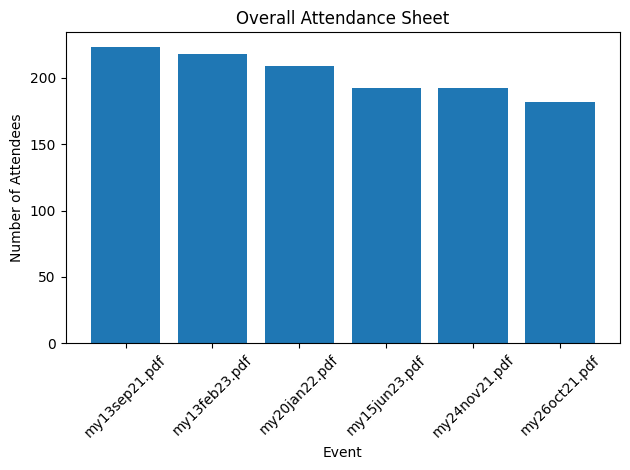

In [12]:
#Version 9.2 (Runtime ~50 seconds for 6 files on Google Colab)

#Find Hansard Reports @ https://www.parlimen.gov.my/hansard-dewan-rakyat.html?&uweb=dr&lang=bm&arkib=yes
#Limitations = [anything before 2021]
#Areas to Improve = [Fix Limitations, Remove political titles for easier data analytics across Cabinets and Parliaments]

#Inputs1:Parameters
pdf_files = [
    '/content/drive/MyDrive/HansardCode/my13feb23.pdf',
    '/content/drive/MyDrive/HansardCode/my13sep21.pdf',
    '/content/drive/MyDrive/HansardCode/my15jun23.pdf',
    '/content/drive/MyDrive/HansardCode/my20jan22.pdf',
    '/content/drive/MyDrive/HansardCode/my24nov21.pdf',
    '/content/drive/MyDrive/HansardCode/my26oct21.pdf'

]

start_phrase = 'Ahli-Ahli Yang Hadir:'
end_phrase = 'Ahli-Ahli Yang Tidak Hadir'
#Inputs2:Desired File Destinations
csv_reference = '/content/drive/My Drive/HansardCode/myoutput1ref.csv' #for reference sheet
output_csv = '/content/drive/My Drive/HansardCode/myoutput1tidy.csv'  #for tidy data (still requires cleaning)

#Inputs3: List of titles
titles = ['Mr', 'Ms', 'Mrs', 'Dr', 'Prof', 'Miss', 'Assoc Prof', 'Tuan', 'Dato', 'Kapten', 'Datuk', 'Puan', 'Menteri', 'Komander', 'Tan Sri','Ir.', 'Tengku', 'Datin']

#code starts here. No Inputs required.
input_csv = csv_reference
from PyPDF2 import PdfReader
import re
import csv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


def extract_text_between_phrases(file_path, start_phrase, end_phrase):
    extracted_text = ""

    with open(file_path, 'rb') as file:
        reader = PdfReader(file)

        for page in reader.pages:
            text = page.extract_text()
            extracted_text += text

    start_index = extracted_text.find(start_phrase)
    end_index = extracted_text.find(end_phrase)

    if start_index != -1 and end_index != -1:
        extracted_text = extracted_text[start_index + len(start_phrase):end_index]
    elif start_index != -1:
        extracted_text = extracted_text[start_index + len(start_phrase):]

    return extracted_text

def extract_strings_from_text(text):
    lines = text.split('\n')
    strings = []
    current_string = ""

    for line in lines:
        line = line.strip()
        if line and line[0].isdigit():
            if current_string:
                strings.append(current_string)
            current_string = line
        else:
            current_string += " " + line

    if current_string:
        strings.append(current_string)

    return strings

def filter_strings(strings):
    filtered_strings = []

    for string in strings:
        # Check if the string contains any of the specified titles
        if any(title in string for title in titles):
            # Remove extra whitespace
            string = ' '.join(string.split())

            if string:
                filtered_strings.append(string)

    return filtered_strings

def remove_starting_spaces(strings):
    return [string.lstrip() for string in strings]

def write_to_csv(file_path, data, pdf_files):
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row with the PDF file names as column headers
        writer.writerow(['Line Number'] + [pdf_file.name for pdf_file in pdf_files])

        # Write the data rows
        max_rows = max(len(data[i]) for i in range(len(data)))
        for i in range(max_rows):
            row_data = [data[j][i] if i < len(data[j]) else '' for j in range(len(data))]
            writer.writerow([i+1] + row_data)

# Process each PDF file
data = []
pdf_files_paths = [Path(pdf_file) for pdf_file in pdf_files]
for pdf_file_path in pdf_files_paths:
    extracted_text = extract_text_between_phrases(pdf_file_path, start_phrase, end_phrase)
    extracted_strings = extract_strings_from_text(extracted_text)

    # Filter lines with titles
    filtered_strings = filter_strings(extracted_strings)

    # Remove empty spaces at the start of lines
    filtered_strings = remove_starting_spaces(filtered_strings)

    data.append(filtered_strings)

# Create Reference Sheet
write_to_csv(csv_reference, data, pdf_files_paths)
print(f"CSV file '{csv_reference}' created successfully. Do note that you might require some data cleaning.")

#Create Tidy Data Sheet
def convert_to_overall_attendance_sheet(input_csv, output_csv):
    # Load the original CSV
    df = pd.read_csv(input_csv)

    # Get the list of event columns (excluding the first column which contains the attendees' names)
    event_columns = df.columns[1:]

    # Initialize an empty DataFrame to store the consolidated attendance data
    overall_attendance = pd.DataFrame(columns=["Person", "Event"])

    # Iterate through each event column in the original DataFrame
    for event_column in event_columns:
        event_name = event_column

        # Extract the attendees' names for the current event
        attendees = df[event_column].dropna().tolist()

        # Create a DataFrame with "Person" and "Event" columns for the current event
        event_attendance = pd.DataFrame({
            "Person": attendees,
            "Event": event_name,
        })

        # Remove the numbers at the beginning of each entry in the "Person" column
        event_attendance["Person"] = event_attendance["Person"].str.replace(r"^\d+\.\s*|\d+\s*", "", regex=True)

        # Concatenate the event attendance data to the overall_attendance DataFrame
        overall_attendance = pd.concat([overall_attendance, event_attendance], ignore_index=True)

    # Write the consolidated data to a new CSV file
    overall_attendance.to_csv(output_csv, index=False)

    return overall_attendance


if __name__ == "__main__":
    overall_attendance_df = convert_to_overall_attendance_sheet(input_csv, output_csv)

    # Count the number of attendees for each event
    event_counts = overall_attendance_df["Event"].value_counts()

    # Create the bar chart
    plt.bar(event_counts.index, event_counts.values)
    plt.xlabel("Event")
    plt.ylabel("Number of Attendees")
    plt.title("Overall Attendance Sheet")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
